In [2]:
!pip install simplejson

     |████████████████████████████████| 130 kB 8.7 MB/s 


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
#from keras.applications.inception_v3 import preprocess_input
#from keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import image
from keras.preprocessing import sequence
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm
from numpy import array
from pickle import load
from PIL import Image
from collections import Counter

import tensorflow as tf
import keras
import re
import pandas as pd
import string
import string
import numpy as np
import pandas as pd
import simplejson as json
import pickle
import matplotlib.pyplot as plt
import glob
import sys
import time
import os
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the captions

In [5]:
filePath = '/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/annotations 2/'

In [6]:
data = json.load(open(filePath + 'train.json', 'r'))
dataset = {}
for key, value in data.items():
    if key != 'annotations':
        dataset[key] = value
dataset['annotations'] = []
for annotation in data['annotations']:
    dataset['annotations'].append(annotation)

In [7]:
image_id = set()
captions = list()
for annotation in dataset['annotations']:
    image_id.add(annotation['image_id'])
    captions.append(annotation['caption'])

In [8]:
df_annotations = pd.json_normalize(dataset, record_path=['annotations'])

In [9]:
df_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117155 entries, 0 to 117154
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   caption        117155 non-null  object
 1   image_id       117155 non-null  int64 
 2   is_precanned   117155 non-null  bool  
 3   is_rejected    117155 non-null  bool  
 4   id             117155 non-null  int64 
 5   text_detected  117155 non-null  bool  
dtypes: bool(3), int64(2), object(1)
memory usage: 3.0+ MB


## Filter precanned and rejected captions

In [10]:
new_df = df_annotations[df_annotations['is_precanned'] == False]

In [11]:
new_df = new_df[new_df['is_rejected'] == False]

In [12]:
i = 1050

while i > 1000:
    tmp_df = new_df[new_df['image_id'] < i] 
    if len(tmp_df['image_id'].unique()) < 1002:
        print(i)
        break
    
    i -= 1

1017


In [13]:
new_df = new_df[new_df['image_id'] < i]

In [14]:
len(new_df['image_id'].unique())

1001

only consider the captions for 1001 images

In [15]:
#df_annotations = df_annotations[0:5005]
df_annotations = new_df.reset_index(drop=True)

In [16]:
df_annotations

,caption,image_id,is_precanned,is_rejected,id,text_detected
0,ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS T...,0,False,False,0,True
1,A green and white plastic condiment bottle con...,0,False,False,1,True
2,A bottle of spices in a plastic container layi...,0,False,False,3,True
3,some basil leaves in a container on a counter,0,False,False,4,True
4,A can of Coca Cola on a counter is shown for w...,1,False,False,5,True
...,...,...,...,...,...,...
4362,Hand holding a package of Betty Crocker brand ...,1015,False,False,5079,True
4363,a person holding a blue can of food to the camera,1016,False,False,5081,True
4364,A person holds a tin can of food in their hand...,1016,False,False,5082,True
4365,Someone holding a can of food near a kitchen c...,1016,False,False,5083,True


## operation to convert the image_id to the name stored in the dataset.

In [17]:
for i in range(0, len(df_annotations)):
    number_str = str(df_annotations["image_id"][i])
    df_annotations["image_id"][i] = 'VizWiz_train_' + number_str.zfill(8)
    if(i < 15):
        print(df_annotations["image_id"][i])

VizWiz_train_00000000
VizWiz_train_00000000
VizWiz_train_00000000
VizWiz_train_00000000
VizWiz_train_00000001
VizWiz_train_00000001
VizWiz_train_00000001
VizWiz_train_00000001
VizWiz_train_00000001
VizWiz_train_00000002
VizWiz_train_00000002
VizWiz_train_00000002
VizWiz_train_00000002
VizWiz_train_00000002
VizWiz_train_00000003


## make a dictionary to store image_id and corresponding captions

In [18]:
df_annotations

,caption,image_id,is_precanned,is_rejected,id,text_detected
0,ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS T...,VizWiz_train_00000000,False,False,0,True
1,A green and white plastic condiment bottle con...,VizWiz_train_00000000,False,False,1,True
2,A bottle of spices in a plastic container layi...,VizWiz_train_00000000,False,False,3,True
3,some basil leaves in a container on a counter,VizWiz_train_00000000,False,False,4,True
4,A can of Coca Cola on a counter is shown for w...,VizWiz_train_00000001,False,False,5,True
...,...,...,...,...,...,...
4362,Hand holding a package of Betty Crocker brand ...,VizWiz_train_00001015,False,False,5079,True
4363,a person holding a blue can of food to the camera,VizWiz_train_00001016,False,False,5081,True
4364,A person holds a tin can of food in their hand...,VizWiz_train_00001016,False,False,5082,True
4365,Someone holding a can of food near a kitchen c...,VizWiz_train_00001016,False,False,5083,True


In [19]:
descriptions = {}

for item in df_annotations.to_numpy():
    
    caption = item[0]
    tokens = caption
    image_id = item[1]
    
    if image_id not in descriptions:
        descriptions[image_id] = list()
    descriptions[image_id].append(tokens)

## Text Processing utilities

In [20]:
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)


def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)


def remove_numeric(text):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)


def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

## Clean the captions reside in descriptions dict

In [21]:
table = str.maketrans('', '', string.punctuation)
for image_id, captions in descriptions.items():
    for i in range(len(captions)):
        desc = captions[i].split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        captions[i] = ' '.join(desc)

In [22]:
descriptions["VizWiz_train_00000000"]

['its is a basil leaves container its contains the net weight too',
 'a green and white plastic condiment bottle containing basil leaves',
 'a bottle of spices in a plastic container laying on a surface',
 'some basil leaves in a container on a counter']

## Visualize the image with captions

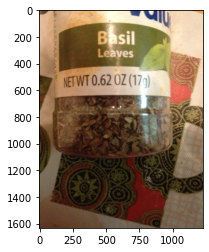

['its is a basil leaves container its contains the net weight too',
 'a green and white plastic condiment bottle containing basil leaves',
 'a bottle of spices in a plastic container laying on a surface',
 'some basil leaves in a container on a counter']

In [23]:
images_path = "/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/Dataset/train/"
pic = 'VizWiz_train_00000000.jpg'
x = plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['VizWiz_train_00000000']

## Total vocabulary size

In [24]:
vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 4052


## Create list of image path

In [25]:
img = glob.glob(images_path + '*.jpg')

In [26]:
img[i].split('/')[-1]

'VizWiz_train_00002503.jpg'

In [27]:
train_images = list()
for key in descriptions.keys():
    train_images.append(key + ".jpg")

In [28]:
train_img = []
for i in img:
    image_name = i.split('/')[-1]
    if image_name in train_images:
        train_img.append(i)

In [29]:
len(train_img)

1001

## Create train description dict with captions starting with startseq and ends with endsq

In [30]:
for image_id, captions in descriptions.items():
    for i in range(len(captions)):
        desc = 'startseq ' + captions[i] + ' endseq'
        descriptions[image_id][i] = desc

In [ ]:
#for image_id , captions in descriptions.items():
#    for i in range(len(captions)):
#      desc = 'startseq ' + ' '.join(captions[i]) + ' endseq'
#      descriptions[image_id][i] = desc

In [31]:
descriptions['VizWiz_train_00000000']

['startseq its is a basil leaves container its contains the net weight too endseq',
 'startseq a green and white plastic condiment bottle containing basil leaves endseq',
 'startseq a bottle of spices in a plastic container laying on a surface endseq',
 'startseq some basil leaves in a container on a counter endseq']

## List of all captions

In [32]:
all_train_captions = []
for key, val in descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [33]:
len(all_train_captions)

4367

## Reduce the vocabulary size

In [34]:
word_count_threshold = 2
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 2401


## Create word embedding

In [35]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [36]:
all_desc = list()
for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 56


## Glove embedding

In [38]:
glove_path = "/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/"
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [39]:
f.close()

## Create embedding matrix

In [40]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
items = wordtoix.items()
for word, i in items:
    if i % 10 == 0:
        print("%d/%d" % (i, vocab_size-1), end='\r')
    
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [41]:
embedding_matrix.shape

(2402, 200)

# Model building

In [58]:
model = InceptionResNetV2(include_top=True, weights='imagenet')

In [59]:
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 149, 149, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 149, 149, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                               

Select the layer before the densly connected layers.

In [60]:
model_new = Model(model.input, model.layers[-2].output)
model_new.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 149, 149, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 149, 149, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                                           

In [61]:
ENCODER_OUTPUT_DIM = model_new.output_shape[1]
ENCODER_INPUT_DIM = (model_new.input_shape[1],model_new.input_shape[2])

In [47]:
model_new.save('models/inceptionresnetv2-encoder.h5')

In [63]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=ENCODER_INPUT_DIM)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    # Some models have a defined preprocess_input
    x = preprocess_input(x)
    return x

def encode(image):
    image = preprocess(image)
    fea_vec = model_new.predict(image)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [49]:
encoding_train = {}
num = 0
for img in train_img:
    num += 1
    if(num % 10 == 0):
        print("Encoding: %d" %(num),end='\r')
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

In [50]:
train_features['VizWiz_train_00000000.jpg'].shape

(1536,)

In [64]:
# Feature Vectors for images
inputs1 = Input(shape=(1536,)) # Shape of Feature vector
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Captions
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 56)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1536)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 56, 200)      480400      ['input_6[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 1536)         0           ['input_5[0][0]']                
                                                                                            

## Transfer learning

In [65]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [66]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 56)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1536)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 56, 200)      480400      ['input_6[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 1536)         0           ['input_5[0][0]']                
                                                                                            

In [67]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

## Train the model in batches

In [68]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n = 0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n += 1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word]
                       for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs

                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical(
                        [out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n = 0

In [69]:
epochs = 40
batch_size = 3
steps = len(descriptions)//batch_size

generator = data_generator(descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/40
333/333 [==============================] - 39s 108ms/step - loss: 5.1872
Epoch 2/40
333/333 [==============================] - 36s 108ms/step - loss: 4.3713
Epoch 3/40
333/333 [==============================] - 36s 108ms/step - loss: 4.0074
Epoch 4/40
333/333 [==============================] - 36s 108ms/step - loss: 3.7289
Epoch 5/40
333/333 [==============================] - 36s 107ms/step - loss: 3.4994
Epoch 6/40
333/333 [==============================] - 36s 108ms/step - loss: 3.2909
Epoch 7/40
333/333 [==============================] - 36s 107ms/step - loss: 3.1278
Epoch 8/40
333/333 [==============================] - 36s 107ms/step - loss: 2.9717
Epoch 9/40
333/333 [==============================] - 36s 108ms/step - loss: 2.8408
Epoch 10/40
333/333 [==============================] - 36s 107ms/step - loss: 2.7056
Epoch 11/40
333/333 [==============================] - 36s 108ms/step - loss: 2.5937
Epoch 12/40
333/333 [==============================] - 36s 107ms/step - lo

In [70]:
model.save('models/inception-resenet-lstm.h5')

# Greedy and beam search

In [71]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [72]:
def beam_search_predictions(image, beam_index=3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences(
                [s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image, par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]

    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []

    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

# Evaluation

In [73]:
def evaluate_image(image_path):
    pic = image_path + '.jpg'
    image = encoding_train[pic].reshape((1, ENCODER_OUTPUT_DIM))
    x = plt.imread(images_path+pic)
    plt.imshow(x)
    plt.show()
    
    print("Ground Truth")
    print([' '.join(sen.split()[1:-1]) for sen in descriptions[image_path]])
    
    print()
    print("Greedy Search:", greedySearch(image))
    print("Beam Search, K = 3:", beam_search_predictions(image, beam_index=3))
    print("Beam Search, K = 5:", beam_search_predictions(image, beam_index=5))
    print("Beam Search, K = 7:", beam_search_predictions(image, beam_index=7))
    #print("Beam Search, K = 10:", beam_search_predictions(image, beam_index=10))

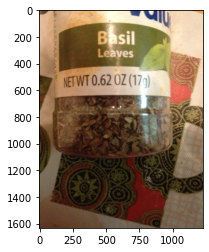

Ground Truth
['its is a basil leaves container its contains the net weight too', 'a green and white plastic condiment bottle containing basil leaves', 'a bottle of spices in a plastic container laying on a surface', 'some basil leaves in a container on a counter']

Greedy Search: a container of orange juice is lying on the counter
Beam Search, K = 3: a blue and orange box of good food is lying on a counter
Beam Search, K = 5: a blue and orange container of good food is lying on a table
Beam Search, K = 7: here is a hand holding a box of some sort its food its is a flavored flavored


In [74]:
evaluate_image('VizWiz_train_00000000')

# Validation Data

Validation data are images 2000 to 20001 in the training set. This section of code preprocess validation captions in the same way as before.

In [75]:
val_data = json.load(open(filePath + 'train.json', 'r'))
val_dataset = {}

for key, value in val_data.items():
    if key != 'annotations':
        val_dataset[key] = value
val_dataset['annotations'] = []

for annotation in val_data['annotations']:
    val_dataset['annotations'].append(annotation)
    
image_id = set()
captions = list()
for annotation in val_dataset['annotations']:
    image_id.add(annotation['image_id'])
    captions.append(annotation['caption'])

df_validation = pd.json_normalize(val_dataset, record_path=['annotations'])

In [76]:
df_validation = df_validation[df_validation["is_precanned"] == False]
df_validation = df_validation[df_validation["is_rejected"] == False]
df_validation = df_validation[df_validation["image_id"] > 1999]

In [77]:
# This block of codes finds the highest image_id so there are still 
# 100 validation images
# This is necessary, because filtering precanned and rejected captions
# may delete some photos.

i = 2150

while i > 1999:
    df_validation = df_validation[df_validation["image_id"] < i]
    
    if len(df_validation['image_id'].unique()) <= 100:
        print(i)
        break
    
    i -= 1

2102


In [78]:
df_validation = df_validation.reset_index(drop=True)

In [79]:
df_validation

,caption,image_id,is_precanned,is_rejected,id,text_detected
0,"Desk with a computer monitor on it, in the for...",2000,False,False,10000,True
1,A white bottle of hair conditioner rests on th...,2000,False,False,10001,True
2,A white bottle of Salon hair conditioner in fr...,2000,False,False,10002,True
3,A mac computer screen with a bottle covering p...,2000,False,False,10003,False
4,The computer screen is large and shows a scree...,2000,False,False,10004,True
...,...,...,...,...,...,...
436,A white and yellow rectangular box of filters ...,2100,False,False,10504,True
437,Two tubes of hand cream on a carpet.,2101,False,False,10505,True
438,a small sample size product laying on the floor,2101,False,False,10506,False
439,a small white tube of cream sitting on a rug w...,2101,False,False,10508,True


In [80]:
for i in range(0, len(df_validation)):
    number_str = str(df_validation["image_id"][i])
    df_validation["image_id"][i] = 'VizWiz_train_' + number_str.zfill(8)
    if(i < 15):
        print(df_validation["image_id"][i])

VizWiz_train_00002000
VizWiz_train_00002000
VizWiz_train_00002000
VizWiz_train_00002000
VizWiz_train_00002000
VizWiz_train_00002001
VizWiz_train_00002001
VizWiz_train_00002001
VizWiz_train_00002001
VizWiz_train_00002002
VizWiz_train_00002002
VizWiz_train_00002002
VizWiz_train_00002002
VizWiz_train_00002002
VizWiz_train_00002003


## Create Dictionary of Image IDs to Captions

In [81]:
val_descriptions = {}

for item in df_validation.to_numpy():
    
    caption = item[0]
    tokens = caption
    image_id = item[1]
    
    if image_id not in val_descriptions:
        val_descriptions[image_id] = list()
    val_descriptions[image_id].append(tokens)

In [82]:
table = str.maketrans('', '', string.punctuation)
for image_id, captions in val_descriptions.items():
    for i in range(len(captions)):
        desc = captions[i].split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        captions[i] = ' '.join(desc)

In [83]:
val_descriptions["VizWiz_train_00002000"]

['desk with a computer monitor on it in the foreground is a bottle of salon conditioner',
 'a white bottle of hair conditioner rests on the desk in front of a computer',
 'a white bottle of salon hair conditioner in front of a computer monitor',
 'a mac computer screen with a bottle covering part of the screen in the image',
 'the computer screen is large and shows a screen full of text']

## Generate Captions and Calculate Bleu Scores

In [84]:
def encode_test(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=ENCODER_INPUT_DIM)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    
    fea_vec = model_new.predict(img)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [98]:
num = 0
total_bleu_score = [0, 0, 0, 0]

results = {}
total_num = len(val_descriptions)

max_bleu = [0, 0, 0, 0]
max_bleus_1 = {}
max_bleus_2 = {}
max_bleus_3 = {}
max_bleus_4 = {}

for key, ground_truth in val_descriptions.items():

    references = [sen.split() for sen in ground_truth]
    pic = key + ".jpg"
    print(pic)
    # Load and Encode Image
    image = encode_test("/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/Dataset/validation/" + pic).reshape((1, ENCODER_OUTPUT_DIM))
    
    captions = []
    
    print("Beam search... k=3  %d/%d" % (num, total_num), end='\r')  
    captions.append(beam_search_predictions(image,3).split())
    
    results[key] = [' '.join(caption) for caption in captions]
    

    total_bleu_score[0] +=  sentence_bleu(references, captions[0], weights=(1,0,0,0)) 
    total_bleu_score[1] +=  sentence_bleu(references, captions[0], weights=(0.5,0.5,0,0)) 
    total_bleu_score[2] +=  sentence_bleu(references, captions[0], weights=(0.33,0.33,0.33,0)) 
    total_bleu_score[3] +=  sentence_bleu(references, captions[0], weights=(0.25,0.25,0.25,0.25))    
        
    bleu_1 =  sentence_bleu(references, captions[0], weights=(1,0,0,0)) 
    bleu_2 =  sentence_bleu(references, captions[0], weights=(0.5,0.5,0,0)) 
    bleu_3 =  sentence_bleu(references, captions[0], weights=(0.33,0.33,0.33,0)) 
    bleu_4 =  sentence_bleu(references, captions[0], weights=(0.25,0.25,0.25,0.25))    
    
    if bleu_1 >= max_bleu[0]:
        max_bleu[0] = bleu_1
        max_bleus_1[pic] = (results[key], bleu_1)
    
    if bleu_2 >= max_bleu[1]:
        max_bleu[1] = bleu_2
        max_bleus_2[pic] = (results[key], bleu_2)
    
    if bleu_3 >= max_bleu[2]:
        max_bleu[2] = bleu_3
        max_bleus_3[pic] = (results[key], bleu_3)
    
    if bleu_4 >= max_bleu[3]:
        max_bleu[3] = bleu_4
        max_bleus_4[pic] = (results[key], bleu_4)
    
    num += 1
    
    
avg_bleu = [i/num for i in total_bleu_score]
print("Average: ",avg_bleu)
print("Total: ",total_bleu_score)

VizWiz_train_00002000.jpg
VizWiz_train_00002001.jpg
VizWiz_train_00002002.jpg
VizWiz_train_00002003.jpg
VizWiz_train_00002004.jpg
VizWiz_train_00002005.jpg
VizWiz_train_00002006.jpg
VizWiz_train_00002007.jpg
VizWiz_train_00002008.jpg
VizWiz_train_00002009.jpg
VizWiz_train_00002010.jpg
VizWiz_train_00002011.jpg
VizWiz_train_00002012.jpg
VizWiz_train_00002013.jpg
VizWiz_train_00002014.jpg
VizWiz_train_00002015.jpg
VizWiz_train_00002016.jpg
VizWiz_train_00002017.jpg
VizWiz_train_00002018.jpg
VizWiz_train_00002019.jpg
VizWiz_train_00002020.jpg
VizWiz_train_00002021.jpg
VizWiz_train_00002022.jpg
VizWiz_train_00002023.jpg
VizWiz_train_00002024.jpg
VizWiz_train_00002025.jpg
VizWiz_train_00002026.jpg
VizWiz_train_00002027.jpg
VizWiz_train_00002028.jpg
VizWiz_train_00002029.jpg
VizWiz_train_00002030.jpg
VizWiz_train_00002031.jpg
VizWiz_train_00002032.jpg
VizWiz_train_00002033.jpg
VizWiz_train_00002034.jpg
VizWiz_train_00002035.jpg
VizWiz_train_00002036.jpg
VizWiz_train_00002037.jpg
VizWiz_train

In [99]:
results

{'VizWiz_train_00002000': ['a bottle of wine is on top of a table'],
 'VizWiz_train_00002001': ['a person holding a sweet seed pod'],
 'VizWiz_train_00002002': ['a box of pasta is on top of a table'],
 'VizWiz_train_00002003': ['pictured is what appears to be a food bottle'],
 'VizWiz_train_00002004': ['a can of beans is on top of a stove'],
 'VizWiz_train_00002005': ['i see a n n n n flavored'],
 'VizWiz_train_00002006': ['a person is holding a bottle of medicine'],
 'VizWiz_train_00002007': ['a bottle of tiger beer is on the table'],
 'VizWiz_train_00002008': ['i see a box of tissue that is green'],
 'VizWiz_train_00002009': ['a person is holding a tin can sitting on a desk'],
 'VizWiz_train_00002010': ['someones hand holding a green box with a mans hand'],
 'VizWiz_train_00002011': ['a close up of a white and white stuffed'],
 'VizWiz_train_00002012': ['a bottle of conditioner sitting on a wooden table'],
 'VizWiz_train_00002013': ['the back side of a bag of some kind'],
 'VizWiz_tr

In [ ]:
plt.close('all')

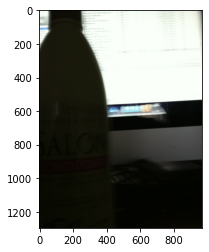

['desk with a computer monitor on it in the foreground is a bottle of salon conditioner', 'a white bottle of hair conditioner rests on the desk in front of a computer', 'a white bottle of salon hair conditioner in front of a computer monitor', 'a mac computer screen with a bottle covering part of the screen in the image', 'the computer screen is large and shows a screen full of text']
Predicted caption: a bottle of wine is on top of a table


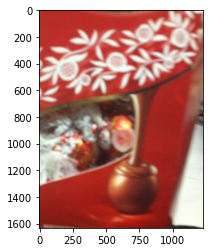

['a small bag of individually wrapped chocolates with a red and white label', 'an ornamental red container is seen in the picture', 'a red and decorated container has some candies inside', 'a box of chocolate candy is on top of a table']
Predicted caption: a person holding a sweet seed pod


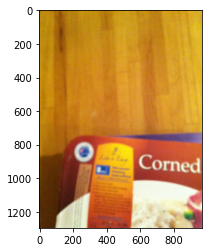

['the upper left corner of a food product package with the word corned in its name placed over a wood floor', 'an image of a packaged food product on top of a table', 'the top of a food package containing a corned beef meal', 'the corner of a package of frozen food that says corned on it', 'a photo of a food item with the wording corned with directions observed']
Predicted caption: a box of pasta is on top of a table


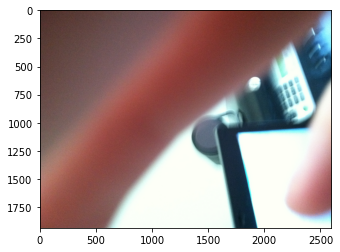

['a desk with a fax machine sitting on it', 'pictured is the top left corner of a tablet or other device', 'someone playing with an ipad near a desk', 'a person is touching their tablet computer with their finger']
Predicted caption: pictured is what appears to be a food bottle


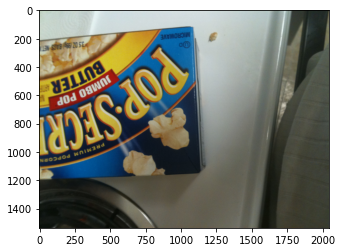

['a box of pop secret brand butter popcorn', 'box of popcorn on a stove top in the kitchen', 'a small blue box of popcorn placed on a stovetop', 'a closed package of microwavable buttered popcorn sitting on top of a stove', 'a box of pop secret microwave popcorn on a kitchen table']
Predicted caption: a can of beans is on top of a stove


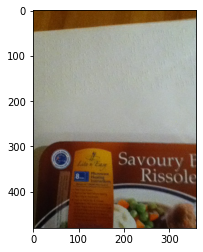

['lite n easy microwave dinner with peas and carrots heats up in 8 minutes', 'a picture of an out of frame tv dinner box', 'a package of frozen pot roast on laying on a table', 'a boxed tv type dinner sets on a white countertop or table', 'a frozen dinner consists of mashed potatoes mixed vegetables and meat in a brown packaging']
Predicted caption: i see a n n n n flavored


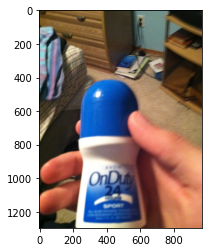

['someone holding a small bottle of avon deodorant', 'a container of antiperspirant is held in the photographers hand with the carpeted floor of a bedroom in the background', 'a person is holding a small container of deodorant the deodorant is branded by the company avon', 'a hand is holding a stick of deodorant', 'a person has a bottle of deodorant in their hand']
Predicted caption: a person is holding a bottle of medicine


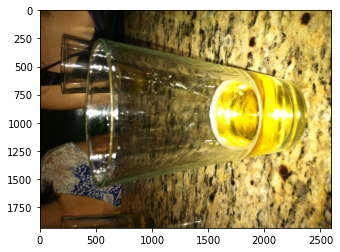

['a drinking glass with about an inch of yellowamber liquid at the bottom', 'a glass with a yellow liquid in it on a counter top', 'a clear glass with a golden liquid is on a counter', 'a glass of beer is on top of a counter']
Predicted caption: a bottle of tiger beer is on the table


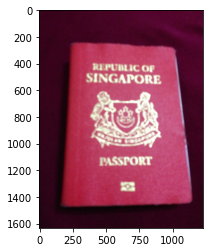

['a red cover passport with gold text sits on some sort of hard surface', 'a red passport is right on top of the bed', 'red republic of singapore passport with emblem on front', 'a red passport from an asian country with a crest on the front', 'pictured is a passport from the republic of singapore']
Predicted caption: i see a box of tissue that is green


In [100]:
for i in range(9):
    try:
        pic = 'VizWiz_train_0000200%d'%(i)
        x = plt.imread('/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/Dataset/validation/' + pic + '.jpg')
        plt.imshow(x)
        plt.show()
        print(val_descriptions[pic])
        print("Predicted caption:",results[pic][0])
    except:
        pass